# Parallel play

Been wanting to try something... anything... parallel for a while. Let's give it a go. 

I'm going on [this blog post](http://blog.dominodatalab.com/simple-parallelization/).

In [1]:
import numpy as np

In [2]:
import multiprocessing as mp

In [3]:
from joblib import Parallel, delayed

## Easy loop

In [4]:
def function(i):  
    return i * i + np.e**(i/np.pi)

In [5]:
def single(n):
    inputs = range(n)
    return [function(i) for i in inputs]

In [7]:
num_cores = mp.cpu_count()
print("Using {0} cores".format(num_cores))
def multi(n):
    inputs = range(n)
    return Parallel(n_jobs=num_cores)(delayed(function)(i) for i in inputs)

Using 8 cores


In [8]:
%timeit single(100)

10000 loops, best of 3: 47.5 µs per loop


In [9]:
%timeit multi(100)

10 loops, best of 3: 146 ms per loop


It worked! But the single-core code is 3000&times; faster, which is a bit underwhelming. Let's try something a bit harder.

## Hard loop

In [10]:
from scipy.signal import ricker

Make a more involved function... 

In [11]:
def conv(n):
    n = (n+2) * 100
    w = ricker(128, 200)
    r = np.random.random((n, n)) - 0.5
    s = np.empty_like(r)
    for i in range(n):
        s[i] = np.convolve(r[i], w, mode='same')
    return s

Redefine what `function` does:

In [12]:
def function(i):  
    return conv(i)

In [13]:
%timeit single(20)

1 loop, best of 3: 2.25 s per loop


In [14]:
%timeit multi(20)

1 loop, best of 3: 3.17 s per loop


OK, that's more like it. Let's plot the advantage.

## Plot the advantage

The usual plotting prelims... 

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

...and we can't use the magic word now, we'll need to use `timeit` directly. 

In [16]:
import timeit

We can only call `timeit` on a function with no arguments, so since we'd like to pass in the number of loops for our job (well, we don't have to I guess), we need a wrapper function. 

In [17]:
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

Test it works by timing 100 loops and reporting the time (divided by 100, for a per-loop time). 

In [18]:
wrapped = wrapper(single, 5)
timeit.timeit(stmt=wrapped, number=100)/100.

0.06691821468004491

It works! Now we can try it for real. 

**WARNING** This takes about 10 minutes on my 2012 iMac with 8 cores. 

In [19]:
singles, multis = [], []

for i in range(25):
    wrapped = wrapper(single, i)
    singles.append(timeit.timeit(wrapped, number=10)/10.)
    wrapped = wrapper(multi, i)
    multis.append(timeit.timeit(wrapped, number=10)/10.)

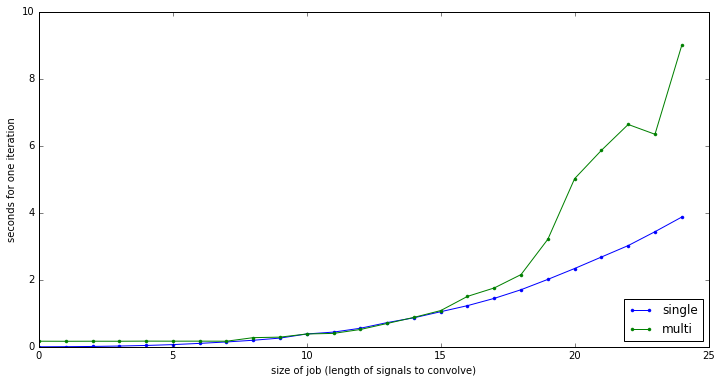

In [20]:
plt.figure(figsize=(12,6))
plt.plot(singles, marker='.', label='single')
plt.plot(multis, marker='.', label='multi')
plt.legend(loc=4)
plt.xlabel('size of job (length of signals to convolve)')
plt.ylabel('seconds for one iteration')
plt.show()

Let's plot the fraction of time taken by parallel version.

Fastest in this test: 232.3% of single-processor time


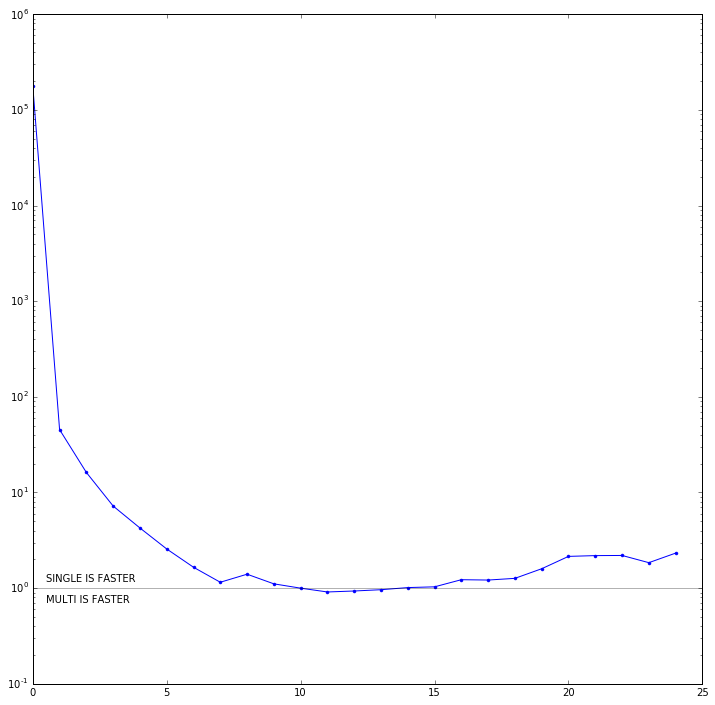

In [22]:
plt.figure(figsize=(12,12))
ratio = np.array(multis)/np.array(singles)
plt.semilogy(ratio[:], marker='.')
plt.axhline(1, color='k', alpha=0.3)
plt.text(0.5, 1.15, 'SINGLE IS FASTER')
plt.text(0.5, 0.70, 'MULTI IS FASTER')
plt.plot()
print("Fastest in this test: {0:.1f}% of single-processor time".format(100*multis[-1]/singles[-1]))